# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi wikipedia. 
Outline of the exercise:
* Dataset preparation
* Preprocessing (25 Points) 
* Exploration (20 Points) 
* TF-IDF + Search (55 Points)

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Section 0: Please enter your name below
# Name: Naser Kazemi
# Student Number: 99102059

# Section 1: Dataset preparation

This section of notebook contains only shell commands. You don't need to completely understand each command or change anything.

Please run all the paragraphs sequentially.

In [1]:
! sudo apt-get -y install wget git

## Download the dump

In [2]:
! wget --no-check-certificate -P.https: // dumps.wikimedia.org / fawiki / latest / fawiki-latest-pages-articles-multistream.xml.bz2

## Extract the dump (this may take a few minutes)

In [3]:
! bzip2 -d fawiki-latest-pages-articles-multistream.xml.bz2

## Clone git project for converting wikipedia xml dump to json

In [4]:
! pip install wikiextractor

## Run the script to convert xml to json (this might take around 30 minutes)

In [5]:
! python -m wikiextractor.WikiExtractor --json fawiki-latest-pages-articles-multistream.xml

## Ensure output files exist

In [6]:
! ls text/*/*

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [7]:
! pip install pyspark

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MDA_2021").config("spark.driver.memory", "32g").config("spark.driver.maxResultSize", "0")\
    .master("local[*]").getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/07 05:04:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Reading the data

In [ ]:
articles_rdd = sc.textFile("text/*/*")
articles_rdd.take(1)

# Section 2: Preprocessing (25 Points)

In this section we will remove useless part (for example /n and /u200c and ...) also find and remove stop words and remove the words with a low count in the corpus

In [3]:
import json

#TODO: parse the json string
json_article_rdd = articles_rdd.map(lambda x: json.loads(x))


#TODO: cleansed text

junk_chars = ['\u200c','\n','(',')','-','.',',',"<<",">>",'"',":","»","«","،",
                  "[","]","}","{","?","!","@","#","$","&","*","_",'"',">","<","؛",
                  "/",'-','%','+','↓','|','\u200e','\u202d','\u202c','=','ـ','\uf0fc',
                  '\u200f','\u200d','%',';','°','//','\u200b','×','.','؟','.','–','۔','\\','^']


def clean_article(x):
    title = x['title']
    text = x['text']
    
    for word in junk_chars:
        title = title.replace(word," ")
    for word in junk_chars:
        text = text.replace(word, " ")
    title = title.replace("  ", " ")
    text = text.replace("  ", " ")
    
    x.update({"title" : title})
    x.update({"text" : text})
    return x


cleansed_articles_rdd = json_article_rdd.map(lambda x: clean_article(x))

In [4]:
words_rdd = cleansed_articles_rdd.flatMap(lambda x: (x['title'], x['text'])).flatMap(lambda x: x.split())
words_count_rdd =  words_rdd.map(lambda x: (x, 1))
words_count = words_count_rdd.reduceByKey(lambda x, y: x + y)

In [5]:
words_count_sorted = words_count.map(lambda x : (x[1], x[0])).sortByKey(False)

In [6]:
from pyspark import StorageLevel
words_count_sorted_persisted = words_count_sorted.persist(StorageLevel.DISK_ONLY)
words_count_ls = words_count_sorted_persisted.collect()

In [ ]:
top_100 = words_count_ls[:100]
top_100

[(5120876, 'در'),
 (4591006, 'و'),
 (3433832, 'به'),
 (2987411, 'از'),
 (2675212, 'است'),
 (2221258, 'که'),
 (2070244, 'می'),
 (1576359, 'این'),
 (1430832, 'را'),
 (1399871, 'های'),
 (1169552, 'با'),
 (992415, 'یک'),
 (874804, 'آن'),
 (869398, 'شده'),
 (835434, 'سال'),
 (736733, 'ها'),
 (698725, 'شد'),
 (630325, 'بود'),
 (623209, 'برای'),
 (546098, 'کرد'),
 (519684, 'او'),
 (494635, 'شود'),
 (439449, 'ای'),
 (437386, 'دارد'),
 (369901, 'خود'),
 (369461, 'بر'),
 (361958, 'تا'),
 (350495, 'ایران'),
 (347286, 'یا'),
 (333296, 'کند'),
 (319739, 'واقع'),
 (300635, 'وی'),
 (292785, 'عنوان'),
 (290140, 'فوتبال'),
 (285060, 'نام'),
 (276302, 'جمعیت'),
 (273265, 'قرار'),
 (260405, 'نیز'),
 (255049, 'باشد'),
 (246531, 'فیلم'),
 (239956, 'کرده'),
 (239938, 'دو'),
 (237583, 'نفر'),
 (231815, 'پس'),
 (224989, 'بازی'),
 (218850, 'باشگاه'),
 (212219, 'شهر'),
 (211982, 'شهرستان'),
 (207427, 'استفاده'),
 (207024, 'بوده'),
 (206938, 'یکی'),
 (205607, 'توسط'),
 (201173, 'اهل'),
 (196933, 'بخش'),
 (186968

In [7]:
#TODO: complete the list of stopwords based on top 100 common words
stopwords = ['', 'خواهد', 'رفت', 'هنوز', 'پيش', 'سال', 'شدن', 'همان', 'دربارهٔ', 
             'بعدها', 'میآید', 'یکی', 'حالی', 'برخی', 'میشوند', 'وقتی', 'زیر', 
             'شدند', 'میکرد', 'هنگامی', 'هاي', 'چه', 'بلکه', 'بودند', 'البته', 
             'می', 'میرسد', 'کرده', 'اوایل', 'شدهاست', 'بودهاست', 'شوند', 'همین', 
             'اگرچه', 'جایی', 'بوده', 'هر', 'شده', 'بین', 'داد', 'معمولاً', 'درون', 
             'که', 'اگر', 'منجر', 'طی', 'هم', 'نامهای', 'مثل', 'مانند', 'رسیده', 
             'دارند', 'ندارد', 'چندین', 'است', 'آمده', 'هستند', 'میتواند', 'را', 
             'باشند', 'فقط', 'میگیرد', 'براساس', 'بر', 'حتی', 'همچنین', 'رسید', 
             'این', 'پس', 'کمی', 'داخل', 'دیگری', 'از', 'موجب', 'چنین', 'بعضی', 
             'همه', 'تر', 'چیزی', 'داشته', 'اما', 'دادند', 'باقی', 'مورد', 'دهد',
             'در', 'قابل', 'پی', 'به', 'های', 'مقابل', 'کسی', 'تعدادی', 'کرد',
             'یا', 'یافته', 'میدهد', 'اي', 'یکدیگر', 'مدتی', 'یافت', 'دادن',
             'میکنند', 'داشت', 'باز', 'نیز', 'سپس', 'خودش', 'میشود', 'جای', 'ولی',
             'گرفت', 'گردید', 'روی', 'میرود', 'گفته', 'کردند', 'خود', 'شد', 
             'کردهاند', 'میکردند', 'هنگام', 'آنان', 'بیش', 'کردن', 'آن', 'سوی', 
             'گرفتن', 'سایر', 'اغلب', 'نامیده', 'میگردد', 'باشد', 'شدهاند', 'نمود', 
             'بعد', 'وی', 'مربوط', 'علاوه', 'کاملاً', 'او', 'کنار', 'اینکه', 'تا', 
             'همراه', 'قرار', 'میگوید', 'گرفته', 'کلی', 'رو', 'میشد', 'و', 'باعث', 
             'آنجا', 'توسط', 'با', 'مثال', 'داشتند', 'گاهی', 'کردهاست', 'سرانجام', 
             'آمد', 'دیده', 'وجود', 'برای', 'بودن', 'ها', 'یعنی', 'هایی', 'اند', 
             'میکند', 'اس', 'بی', 'بود', 'تمامی', 'شود', 'کنند', 'دارد', 'ان', 'اکنون', 
             'یک', 'بسیاری', 'دیگر', 'شکل', 'حدود', 'ای', 'کند', 'میدهند']


def remove_stopwords(article):
    title = article['title']
    text = article['text']
    title = ' '.join([word for word in title.split() if word not in stopwords])
    text = ' '.join([word for word in text.split() if word not in stopwords])
    article['title'] = title
    article['text'] = text
    return article
    

articles_without_stopwords_rdd = cleansed_articles_rdd.map(lambda x: remove_stopwords(x))

In [8]:
words_without_stopwords_rdd = articles_without_stopwords_rdd.flatMap(lambda x: (x['title'],
                                                                                          x['text'])).flatMap(lambda x: x.split())
words_without_stopwords_count_rdd =  words_without_stopwords_rdd.map(lambda x: (x, 1))
words_without_stopwords_count = words_without_stopwords_count_rdd.reduceByKey(lambda x, y: x + y)

In [9]:
words_without_stopwords_count_persisted = words_without_stopwords_count.persist(StorageLevel.DISK_ONLY)
words_count_sorted_rdd = words_without_stopwords_count_persisted.map(lambda x : (x[1], x[0])).sortByKey(False)
words_count_sorted_rdd_persisted = words_count_sorted_rdd.persist(StorageLevel.DISK_ONLY)
words_count_ls = words_count_sorted_rdd.collect()

In [10]:
top_100 = words_count_ls[:100]
top_100

[(350495, 'ایران'),
 (319739, 'واقع'),
 (292785, 'عنوان'),
 (290140, 'فوتبال'),
 (285060, 'نام'),
 (276302, 'جمعیت'),
 (246531, 'فیلم'),
 (239938, 'دو'),
 (237583, 'نفر'),
 (224989, 'بازی'),
 (218850, 'باشگاه'),
 (212219, 'شهر'),
 (211982, 'شهرستان'),
 (207427, 'استفاده'),
 (201173, 'اهل'),
 (196933, 'بخش'),
 (170501, 'استان'),
 (167729, 'توان'),
 (165761, 'آمریکا'),
 (159976, 'ملی'),
 (152383, 'کشور'),
 (150848, 'اشاره'),
 (150490, 'شرکت'),
 (145287, 'کار'),
 (144902, 'میلادی'),
 (142909, 'ایالات'),
 (142335, 'متحده'),
 (133682, 'صورت'),
 (130595, 'زادهٔ'),
 (126788, 'تاریخ'),
 (125612, 'تیم'),
 (125587, 'زمان'),
 (125542, 'زبان'),
 (122010, 'دست'),
 (119922, 'پیش'),
 (115668, 'داده'),
 (112020, 'روستا'),
 (111222, 'سطح'),
 (110304, 'گروه'),
 (109920, 'دانشگاه'),
 (106427, 'زندگی'),
 (104970, 'کتاب'),
 (103150, 'متر'),
 (101188, 'انجام'),
 (99806, 'دوره'),
 (99767, 'سه'),
 (99454, 'جنگ'),
 (98227, 'بازیکن'),
 (97251, 'بزرگ'),
 (97049, 'مرکز'),
 (96804, 'طور'),
 (95466, 'نقش'),
 (95019

In [10]:
MIN_COUNT = 20
uncommon_words =  words_count_sorted_rdd.filter(lambda x: x[0] < MIN_COUNT).map(lambda x: x[1]).collect()

In [11]:
common_words =  words_count_sorted_rdd.filter(lambda x: x[0] >= MIN_COUNT).map(lambda x: x[1]).collect()

In [12]:
#TODO: remove uncommon words from articles_without_stopwords_rdd

def word_hash(word, mod):
    tmp = 0
    for w in word:
        tmp += ord(w)
    tmp *= len(word)
    return tmp % mod
    

bucket_size = 1000
hashed_words = [[] for _ in range(bucket_size)]
for word in common_words:
    hashed_words[word_hash(word, bucket_size)].append(word)


def remove_uncommon_words(article):
    title = article['title']
    text = article['text']
    
    title_words = [word for word in title.split() if word != '' and word in hashed_words[word_hash(word, bucket_size)]]
    text_words = [word for word in text.split() if word != '' and word in hashed_words[word_hash(word, bucket_size)]]
    
    article['title'] = ' '.join(title_words)
    article['text'] = ' '.join(text_words)
    return article

In [13]:
articles_cleaned_rdd = articles_without_stopwords_rdd.map(lambda x: remove_uncommon_words(x))
articles_cleaned_rdd_persisted = articles_cleaned_rdd.persist(StorageLevel.DISK_ONLY)
articles_cleaned = articles_cleaned_rdd_persisted.collect()

# Section 3: Exploration (20 Points)
Please answer the following questions regarding the dataset:

* How many unique 3-Letter words remain after the cleaning procedure?

In [14]:
words_cleaned_rdd = articles_cleaned_rdd_persisted.flatMap(lambda x: (x['title'], x['text'])).flatMap(lambda x: x.split())

In [16]:
words_cleaned_rdd.filter(lambda x: len(x) == 3).distinct().count()

9495

* What are the top 20 most common English trigrams in the corpus?

In [15]:
def trigram(text):
    words = text.split()
    trigrams = []
    for i in range(len(words) - 2):
        trigrams.append((words[i], words[i+1], words[i+2]))
    return trigrams


def is_english(words):
    for word in words:
        try:
            word.encode(encoding='utf-8').decode('ascii')
        except UnicodeDecodeError:
            return False
    return True



english_trigrams_rdd = articles_cleaned_rdd_persisted.flatMap(lambda x: (x['title'], x['text'])).flatMap(lambda x: trigram(x))\
    .filter(lambda x: is_english(x))
english_trigrams_rdd_persisted = english_trigrams_rdd.persist(StorageLevel.DISK_ONLY)
english_trigrams = english_trigrams_rdd_persisted.collect()


In [ ]:
english_trigrams_count_rdd = english_trigrams_rdd_persisted.map(lambda x: (x, 1))
english_trigrams_count_rdd_persisted = english_trigrams_count_rdd.persist(StorageLevel.DISK_ONLY)
english_trigrams_count = english_trigrams_count_rdd_persisted.reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], False).collect()

In [18]:

top_20 = english_trigrams_count[:20]
top_20

[(('en', 'wikipedia', 'org'), 4796),
 (('http', 'en', 'wikipedia'), 3722),
 (('The', 'Free', 'Encyclopedia'), 3645),
 (('Wikipedia', 'The', 'Free'), 3645),
 (('w', 'index', 'php'), 3471),
 (('org', 'w', 'index'), 3470),
 (('wikipedia', 'org', 'w'), 3470),
 (('index', 'php', 'title'), 3456),
 (('Free', 'Encyclopedia', 'http'), 2814),
 (('Encyclopedia', 'http', 'en'), 2809),
 (('amp', 'oldid', 'accessed'), 2468),
 (("women's", 'national', 'under'), 1893),
 (('wikipedia', 'org', 'wiki'), 1571),
 (('gt', 'lt', 'contributor'), 1254),
 (('contributor', 'gt', 'lt'), 1254),
 (('lt', 'ns', 'gt'), 1254),
 (('lt', 'timestamp', 'gt'), 1254),
 (('lt', 'contributor', 'gt'), 1254),
 (('lt', 'model', 'gt'), 1252),
 (('lt', 'format', 'gt'), 1252)]

* Plot a distribution from document lengths using appropriate bin sizes with 100 bins

In [ ]:
documents_lengths_rdd = articles_cleaned_rdd_persisted.map(lambda x: (x, len(x['text'].split()))).sortBy(lambda x: x[1], False)
documents_lengths_persisted = documents_lengths_rdd.persist(StorageLevel.DISK_ONLY)
documents_length = documents_lengths_persisted.collect()

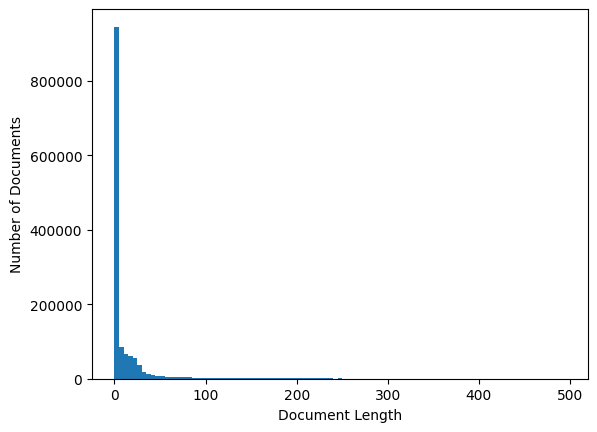

In [19]:
import matplotlib.pyplot as plt

plt.hist([x[1] for x in documents_length], bins=list(range(0, 500, 5)))

plt.xlabel('Document Length')
plt.ylabel('Number of Documents')

plt.show()

* What are the titles and urls of the 5 longest articles? 

In [20]:
top_5 = documents_length[:5]
for doc in top_5:
    print(f'document title: {doc[0]["title"]}')
    print(f'document length: {doc[1]}')
    print(f'document URL: {doc[0]["url"]}')
    print('\n**************\n')

document title: نادرشاه
document length: 14294
document URL: https://fa.wikipedia.org/wiki?curid=10787

**************

document title: جمهوری وایمار
document length: 12704
document URL: https://fa.wikipedia.org/wiki?curid=26519

**************

document title: حافظ
document length: 12657
document URL: https://fa.wikipedia.org/wiki?curid=44114

**************

document title: اسلام
document length: 12220
document URL: https://fa.wikipedia.org/wiki?curid=1567

**************

document title: اسلام
document length: 12220
document URL: https://fa.wikipedia.org/wiki?curid=1567

**************



# Section 4: TF-IDF + Searching (55 Points)

In [16]:
#TODO: calculate document frequncy for each word
word_df_rdd = articles_cleaned_rdd_persisted.flatMap(lambda x: [((x['id'], word), 1) for word in x['text'].split()])
# doc -> ((doc_id, word), 1)
word_df_rdd_persisted = word_df_rdd.persist(StorageLevel.DISK_ONLY)
word_df_reduced_rdd = word_df_rdd_persisted.reduceByKey(lambda x, y: x + y)
# doc -> ((doc_id, word), df)
word_df_reduced_rdd_persisted = word_df_reduced_rdd.persist(StorageLevel.DISK_ONLY)
word_df = word_df_reduced_rdd_persisted.collect()

In [ ]:
# (word, (doc_id, df))
tf_rdd = word_df_reduced_rdd_persisted.map(lambda x: (x[0][1],(x[0][0],x[1])))
tf_rdd_persisted = tf_rdd.persist(StorageLevel.DISK_ONLY)
tf_rdd_persisted.collect()

In [ ]:
# (word, (doc_id, df, 1))
idf_rdd = word_df_reduced_rdd_persisted.map(lambda x: (x[0][1], (x[0][0], x[1], 1)))
idf_rdd_persisted = idf_rdd.persist(StorageLevel.DISK_ONLY)
idf_rdd_persisted.collect()

In [19]:
word_freq_rdd = idf_rdd_persisted.map(lambda x: (x[0], x[1][2])).reduceByKey(lambda x, y: x + y)
word_freq_rdd_persisted = word_freq_rdd.persist(StorageLevel.DISK_ONLY)
word_freq = word_freq_rdd_persisted.collect()

In [20]:
import math

In [ ]:
N = len(articles_cleaned)
idf_rdd = word_freq_rdd_persisted.map(lambda x: (x[0], math.log(1 + N / x[1])))
idf_rdd_persisted = idf_rdd.persist(StorageLevel.DISK_ONLY)
idf_rdd_persisted.collect()

In [ ]:
tf_idf_rdd = tf_rdd_persisted.join(idf_rdd_persisted)
tf_idf_rdd_persisted = tf_idf_rdd.persist(StorageLevel.DISK_ONLY)
tf_idf_rdd_persisted.collect()

In [ ]:
tf_idf_result_rdd = tf_idf_rdd_persisted.map(lambda x: (x[1][0][0],(x[0],x[1][0][1],x[1][1],x[1][0][1]*x[1][1]))).sortByKey()
tf_idf_result_rdd_persisted = tf_idf_result_rdd.persist(StorageLevel.DISK_ONLY)
tf_idf_result = tf_idf_result_rdd_persisted.collect()

In [24]:
# (doc_id, (word, tf, idf, tf_idf))
tf_idf_result[:2]

[('100011', ('دقیقی', 3, 7.571362789061969, 22.71408836718591)),
 ('100011', ('جانشین', 1, 6.236344592391012, 6.236344592391012))]

In [25]:
#TODO: add `vector` key to articles_cleaned_rdd dictionary with the tf_idf dictionary
articles_tf_idf_vectors = tf_idf_result_rdd_persisted.map(lambda x: (x[0], {x[1][0]: x[1][3]})).reduceByKey(lambda x, y: {**x, **y}).collect()
articles_tf_idf_vectors = {x[0]: x[1] for x in articles_tf_idf_vectors}

def add_tf_idf_vector(article):
    article['vector'] = articles_tf_idf_vectors.get(article['id'], [])
    return article
    
articles_cleaned_rdd = articles_cleaned_rdd.map(lambda x: add_tf_idf_vector(x))

* How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]

In [ ]:
# How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]
topics = ['تاریخ', 'سیاست', 'پزشکی', 'قانون', 'اقتصاد', 'مهندسی']
articles_with_topic_rdd = tf_rdd_persisted.filter(lambda x: x[0] in topics)
articles_with_topic = articles_with_topic_rdd.collect()

In [ ]:
topic_count = articles_with_topic_rdd.map(lambda x: (x[0], x[1][1])).reduceByKey(lambda x, y: x + y).collect()
topic_count

[('سیاست', 143),
 ('اقتصاد', 92),
 ('مهندسی', 134),
 ('قانون', 195),
 ('تاریخ', 693),
 ('پزشکی', 136)]

In [ ]:
topic_with_ariticles_id = articles_with_topic_rdd.map(lambda x: (x[0], x[1][0])).groupByKey().mapValues(list).collect()
topics_dict = {x[0]: x[1] for x in topic_with_ariticles_id}
topics_dict

## Searching
In this section you should find articles that are about the topics mentioned in the last part of the third section.
Report the percentage of articles that are about the mentioned topics, for example, report what percentage of the articles were about history?
For each topic, report two of the most relevant articles along with the title and the url.
Check this part in **theory** before practical implementation (Hint: Use the concept of tf-idf).
All innovative solutions are also welcome. Compare the obtained results with the third part.

In [ ]:
docs = []
for topic in topics_dict.keys():
    docs.extend(topics_dict[topic])
docs = set(docs)
    

In [ ]:
articles_with_topics_rdd = articles_cleaned_rdd.filter(lambda x: x['id'] in docs)
articles_with_topics = articles_with_topics_rdd.collect()

In [ ]:
words = word_df_reduced_rdd.map(lambda x: x[0][1]).collect()
words_tf_idf = {x: 0 for x in words}
def assign_tf_idf_to_words(article):
    tmp = words_tf_idf.copy()
    tmp.update(article['vector'])
    article['vector'] = tmp
    return (article['id'], article['vector'])

tf_idf_matrix_rdd = articles_with_topics_rdd.map(lambda x: assign_tf_idf_to_words(x))
tf_idf_matrix = tf_idf_matrix_rdd.collect()

In [ ]:
import pandas as pd
tf_idf_matrix_df = pd.DataFrame(tf_idf_matrix, columns=['id', 'vector'])    
tf_idf_matrix_df = tf_idf_matrix_df.set_index('id')
tf_idf_matrix_df = tf_idf_matrix_df['vector'].apply(pd.Series)
tf_idf_matrix_df = tf_idf_matrix_df.fillna(0)
tf_idf_matrix_df.head()

,ژول,سالانه,ارتفاع,شرح,زمین,دم,کشور,نوشته,رهبری,باستان,...,گزش,کلیتوریس,هرثمه,وینچستر,وینوکوروف,کیدز,گلنس,فیروزجا,کاشفی,کلمسون
id,,,,,,,,,,,,,,,,,,,,,
2269,0.0,0.000000,0.000000,0.000000,14.141219,0.0,3.438098,0.000000,5.737575,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2603,0.0,25.628668,0.000000,5.164715,28.282439,0.0,147.838226,4.595333,0.000000,11.039347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3220,0.0,6.407167,0.000000,0.000000,4.713740,0.0,10.314295,4.595333,0.000000,16.559021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3345,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.190666,0.000000,5.519674,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4094,0.0,0.000000,14.071269,5.164715,28.282439,0.0,79.076260,13.786000,5.737575,22.078694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# search for ariticles with the word `تاریخ` in tf_idf_matrix_df
related = tf_idf_matrix_df[tf_idf_matrix_df['تاریخ'] > 0]
# sort by tf_idf value
related = related.sort_values(by='تاریخ', ascending=False)
related

,ژول,سالانه,ارتفاع,شرح,زمین,دم,کشور,نوشته,رهبری,باستان,...,گزش,کلیتوریس,هرثمه,وینچستر,وینوکوروف,کیدز,گلنس,فیروزجا,کاشفی,کلمسون
id,,,,,,,,,,,,,,,,,,,,,
439490,0.0,0.0,0.000000,5.164715,23.568699,0.00000,61.885769,22.976666,22.950302,662.360833,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4094,0.0,0.0,14.071269,5.164715,28.282439,0.00000,79.076260,13.786000,5.737575,22.078694,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4975637,0.0,0.0,0.000000,0.000000,0.000000,0.00000,6.876197,4.595333,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,391.184359,0.0,0.0,0.0,0.0
4254,0.0,0.0,0.000000,25.823573,9.427480,24.43699,41.257179,50.548666,0.000000,11.039347,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
5634034,0.0,0.0,0.000000,0.000000,108.416016,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672231,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
671507,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
671309,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


: 